<a href="https://colab.research.google.com/github/ArmFriiz/Dicoding-Submission-FDL/blob/main/Analisis%20Sentimen/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load package dan library**

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.2 MB/s eta 0:00:00


In [ ]:
import re
import kagglehub
import gensim
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, concatenate, Input, LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [ ]:
path = kagglehub.dataset_download("bhimantoros/pretrained-word2vec-indonesia")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pretrained-word2vec-indonesia' dataset.
Path to dataset files: /kaggle/input/pretrained-word2vec-indonesia


In [ ]:
fix_path = os.path.join(path, "wiki.id.case.model")
print("Path to model file:", fix_path)

Path to model file: /kaggle/input/pretrained-word2vec-indonesia/wiki.id.case.model


**Load dataset sentimen**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore.csv')

In [ ]:
df.head()

,content,score,label
0,CEPAT AMAN TERPERCAYA,5,Positif
1,top markotop,5,Positif
2,belanja online nomor 1 satu di Indonesia.,5,Positif
3,GANGGU DOANG LU ORG LAGI MAIN JUGA,1,Negatif
4,jadi langganan belanja di shopee..,5,Positif


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73478 entries, 0 to 73477
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  73478 non-null  object
 1   score    73478 non-null  int64 
 2   label    73478 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
df.describe(include='all')

,content,score,label
count,73478,73478.000000,73478
unique,72705,NaN,3
top,bagus,NaN,Positif
freq,5,NaN,51173
mean,NaN,3.862802,NaN
std,NaN,1.668418,NaN
min,NaN,1.000000,NaN
25%,NaN,2.000000,NaN
50%,NaN,5.000000,NaN
75%,NaN,5.000000,NaN


**Load dataset tambahan**

In [ ]:
# df_tambahan_netral = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore_netral.csv')

In [ ]:
# df_tambahan_netral.info()

In [ ]:
# df_tambahan_negatif = pd.read_csv('https://raw.githubusercontent.com/ArmFriiz/Dicoding-Submission-FDL/refs/heads/main/Analisis%20Sentimen/dataset_ulasan_playstore_negatif.csv')

In [ ]:
# df_tambahan_negatif.info()

**Gabungkan dataset utama dan tambahan**

In [ ]:
# df = pd.concat([main_df, df_tambahan_netral, df_tambahan_negatif]).reset_index(drop=True)

**Drop column score karena hanya digunakan untuk labelling awal saja**

In [ ]:
df.drop(columns=['score'], inplace=True)

In [ ]:
df.columns

Index(['content', 'label'], dtype='object')

**Cek ulang kondisi data**

In [ ]:
df.isna().sum()

,0
content,0
label,0


In [ ]:
df.duplicated().sum()

np.int64(472)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe(include='all')

,content,label
count,73006,73006
unique,72705,3
top,bagus dan cepat,Positif
freq,3,50760


**Load model normalisasi kata untuk perbaikan kata slank atau typo**

In [ ]:
normalization_df = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv')

In [ ]:
normalization_df.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [ ]:
normalization_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15006 entries, 0 to 15005
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   slang          15006 non-null  object
 1   formal         15006 non-null  object
 2   In-dictionary  15006 non-null  int64 
 3   context        15006 non-null  object
 4   category1      15006 non-null  object
 5   category2      15006 non-null  object
 6   category3      15006 non-null  object
dtypes: int64(1), object(6)
memory usage: 820.8+ KB


In [ ]:
normalization_dict = dict(zip(normalization_df['slang'], normalization_df['formal']))

**Cleaning data (Case folding, Punctuation, Kata berulang, Slankword atau typo)**

In [ ]:
def cleaning_text(text, normalization_dict):
  text = text.lower() # Ubah teks menjadi huruf kecil
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mention
  text = re.sub(r'http\S+', '', text) # Hapus URL
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
  text = re.sub(r'(.)\1{2,}', r'\1\1', text) # Hapus kata berulang yang muncul lebih dari 2x

  words = text.split()
  words = [normalization_dict.get(word, word) for word in words]
  text = ' '.join(words)

  text = ''.join([char for char in text if char.isalpha() or char.isspace()])
  text = ' '.join(text.split()) # Bersihkan spasi berlebih di tengah dan di ujung
  return text

In [ ]:
df['clean_content'] = df['content'].apply(cleaning_text, normalization_dict=normalization_dict)

In [ ]:
df.head()

,content,label,clean_content
0,CEPAT AMAN TERPERCAYA,Positif,cepat aman terpercaya
1,top markotop,Positif,top markotop
2,belanja online nomor 1 satu di Indonesia.,Positif,belanja online nomor satu di indonesia
3,GANGGU DOANG LU ORG LAGI MAIN JUGA,Negatif,ganggu doang lu orang lagi main juga
4,jadi langganan belanja di shopee..,Positif,jadi langganan belanja di shopee


**Cek jumlah label data dan kata yang terkandung pada data sebelum resample**

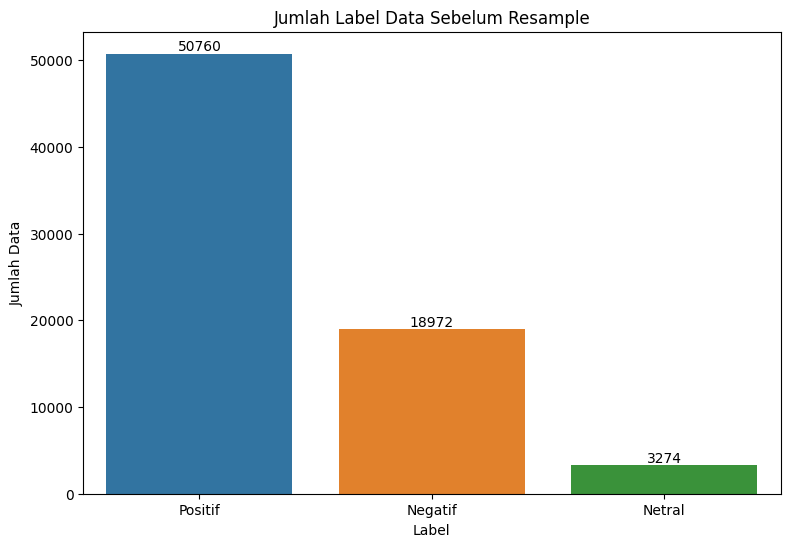

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, hue=df['label'].value_counts().index)
plt.title('Jumlah Label Data Sebelum Resample')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.bar_label(plt.gca().containers[0])
plt.bar_label(plt.gca().containers[1])
plt.bar_label(plt.gca().containers[2])
plt.show()

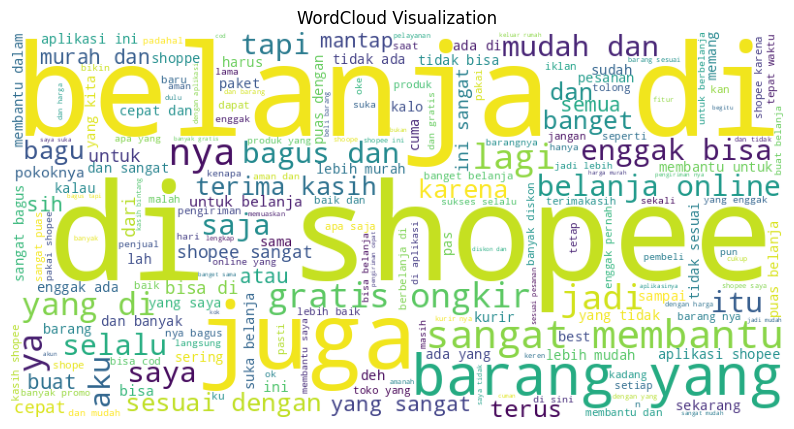

In [ ]:
positif_content = df[df['label'] == 'Positif']['clean_content']

all_words = ''.join(positif_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

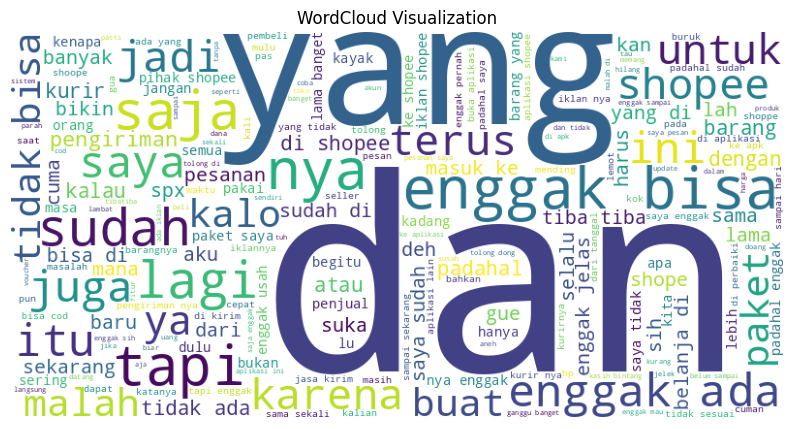

In [ ]:
negatif_content = df[df['label'] == 'Negatif']['clean_content']

all_words = ''.join(negatif_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

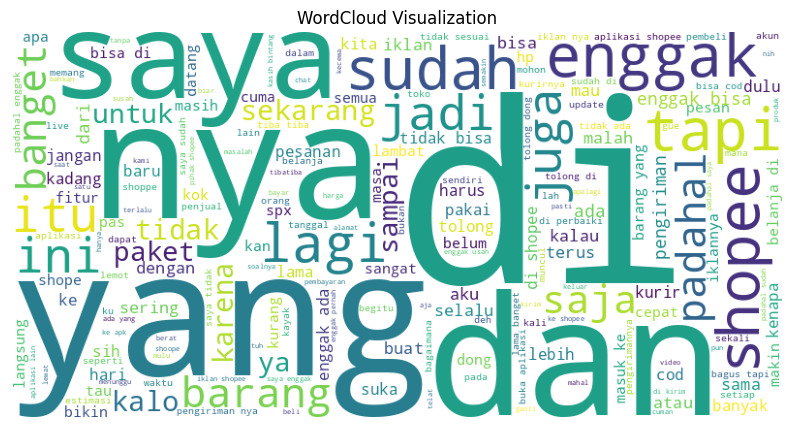

In [ ]:
netral_content = df[df['label'] == 'Netral']['clean_content']

all_words = ''.join(netral_content)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud Visualization')
plt.show()

**Resample data berdasarkan class rata-rata**

In [ ]:
df_negatif = df[df['label'] == 'Negatif']
df_netral = df[df['label'] == 'Netral']
df_positif = df[df['label'] == 'Positif']

n_samples = len(df_positif)

df_netral_downsample = resample(df_netral, replace=True, n_samples=n_samples, random_state=42)
df_negatif_downsample = resample(df_negatif, replace=True, n_samples=n_samples, random_state=42)

df_balanced = pd.concat([df_positif, df_negatif_downsample, df_netral_downsample])

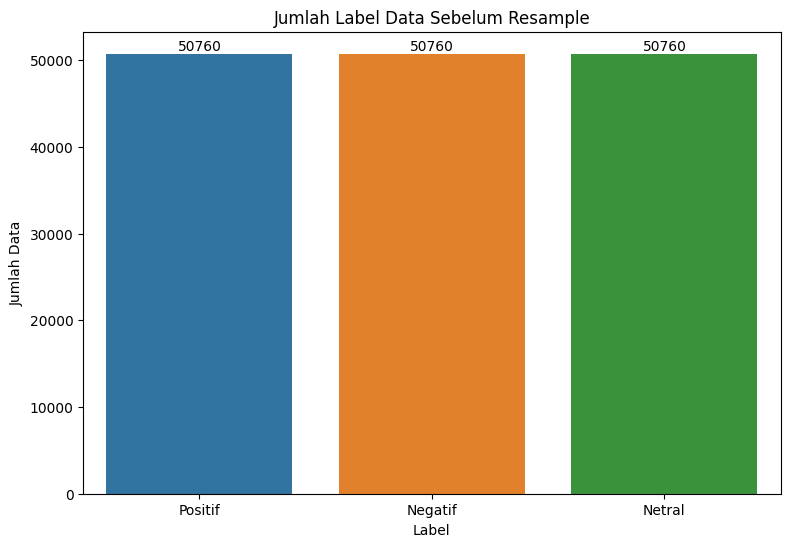

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(x=df_balanced['label'].value_counts().index, y=df_balanced['label'].value_counts().values, hue=df_balanced['label'].value_counts().index)
plt.title('Jumlah Label Data Sebelum Resample')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.bar_label(plt.gca().containers[0])
plt.bar_label(plt.gca().containers[1])
plt.bar_label(plt.gca().containers[2])
plt.show()

**Encoding label data**

In [ ]:
le = LabelEncoder()
df_balanced['label_encoded'] = le.fit_transform(df_balanced['label'])

In [ ]:
df_balanced.head()

,content,label,clean_content,label_encoded
0,CEPAT AMAN TERPERCAYA,Positif,cepat aman terpercaya,2
1,top markotop,Positif,top markotop,2
2,belanja online nomor 1 satu di Indonesia.,Positif,belanja online nomor satu di indonesia,2
4,jadi langganan belanja di shopee..,Positif,jadi langganan belanja di shopee,2
5,mantap,Positif,mantap,2


In [ ]:
x = df_balanced['clean_content'].values

In [ ]:
print(x)

['cepat aman terpercaya' 'top markotop'
 'belanja online nomor satu di indonesia' ...
 'pesanan sudah dikirim malah terhambat dan sudah lewat dari waktu yang ditentukan sudah bayar shopeepay malah mau dikirim lagi sama penjual aneh banget pengiriman shopee sekarang tidak rekomend'
 'buka aplikasi shopee selalu video yang nungul mana barangnya hapus cache n data tetap saja video n live yang nungul di awal semakin tidak nyaman'
 'puas banget blanja disini ya meskipun banyak pedagang yang tidak amanahcuman satu yang bikin saya sama sekali enggak nyamanstiap buka aplikasi shopee selalu saja muncul vidio live atau vidio postingan orang lain yang enggak jelas dan terlalu lumrah di medsos lainyajujur itu sangat menggangu kita mau cari barang pun malah harus melihat vidio tersebut']


In [ ]:
y = df_balanced['label_encoded'].values

In [ ]:
print(y)
print(le.classes_)

[2 2 2 ... 1 1 1]
['Negatif' 'Netral' 'Positif']


In [ ]:
y_onehot = to_categorical(y, num_classes=3)
y_onehot

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

**Splitting Data (Training-Testing-Validation) (80-20)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.20, random_state=42, stratify=y)

print(f"Jumlah Data Train : {len(X_train)}")
print(f"Jumlah Data Test  : {len(X_test)}")

Jumlah Data Train : 121824
Jumlah Data Test  : 30456


**Tokenization, sequence dan padding**

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

lens = [len(s) for s in X_train_seq]
# max_len = int(np.percentile(lens, 95))
max_len = max(lens)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='pre', truncating='pre')
X_test_pad = pad_sequences(X_test_seq,  maxlen=max_len, padding='pre', truncating='pre')

In [ ]:
print("Ukuran Sequences : ", max_len)

Ukuran Sequences :  103


**Load model Word2Vec untuk transfer learning (input model)**

In [ ]:
w2v_model = gensim.models.Word2Vec.load(fix_path).wv

In [ ]:
EMBEDDING_DIM = 400

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

hits = 0
misses = 0

for word, i in word_index.items():
  if word in w2v_model:
    embedding_matrix[i] = w2v_model[word]
    hits += 1
  else:
    misses += 1

print(f"Berhasil: {hits}, Gagal (OOV): {misses}")

Berhasil: 11352, Gagal (OOV): 25950


**Balancing class menggunakan pembobotan**

In [ ]:
# y_train_int = np.argmax(y_train, axis=1)

# class_weights_val = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_int),
#     y=y_train_int
# )
# class_weights_dict = dict(enumerate(class_weights_val))
# print(class_weights_dict)

**Modelling**

**BI-LSTM + Word Embedding**

In [ ]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)
x = LayerNormalization()(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [ ]:
model_1 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_1 = model_1.fit(X_train_pad,
            y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1)

Epoch 1/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - accuracy: 0.6644 - loss: 0.9196 - val_accuracy: 0.8629 - val_loss: 0.3994
Epoch 2/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 67s 17ms/step - accuracy: 0.8658 - loss: 0.4029 - val_accuracy: 0.8794 - val_loss: 0.3439
Epoch 3/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - accuracy: 0.9007 - loss: 0.3078 - val_accuracy: 0.9045 - val_loss: 0.2843
Epoch 4/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - accuracy: 0.9153 - loss: 0.2601 - val_accuracy: 0.9212 - val_loss: 0.2463
Epoch 5/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - accuracy: 0.9267 - loss: 0.2246 - val_accuracy: 0.9176 - val_loss: 0.2493
Epoch 6/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 70s 18ms/step - accuracy: 0.9333 - loss: 0.2067 - val_accuracy: 0.9256 - val_loss: 0.2397
Epoch 7/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - accuracy: 0.9385 - loss: 0.1883 - val_accuracy: 0.9332 - val_loss: 0.2338
Epoch 8/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 70s 18ms/step - accuracy: 0.9425 -

In [ ]:
model_1.evaluate(X_test_pad, y_test)

952/952 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9449 - loss: 0.2439


[0.2526916265487671, 0.9433937668800354]

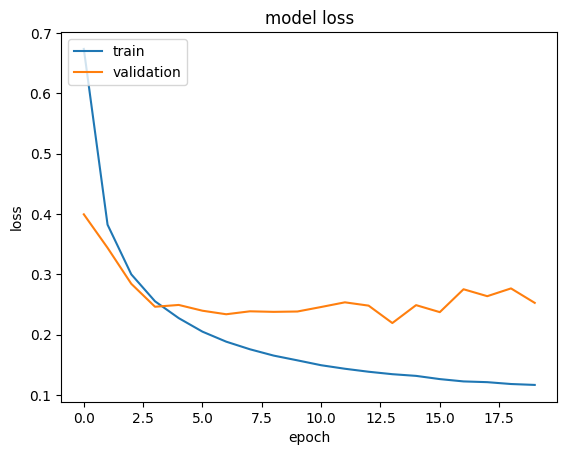

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
model_1.save('model_1.h5')

**BI-LSTM + Word Embedding + Word2Vec Pre-Trained**

In [ ]:
inputs = Input(shape=(max_len,))

x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAvgPool1D()(x)

concatenated = concatenate([max_pool, avg_pool])

x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)

In [ ]:
model_2 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_2 = model_2.fit(X_train_pad,
            y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_test_pad, y_test),
            verbose=1)

Epoch 1/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.5504 - loss: 0.9557 - val_accuracy: 0.6524 - val_loss: 0.7458
Epoch 2/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.6393 - loss: 0.7844 - val_accuracy: 0.6959 - val_loss: 0.7086
Epoch 3/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.6689 - loss: 0.7424 - val_accuracy: 0.7146 - val_loss: 0.6763
Epoch 4/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.6925 - loss: 0.7128 - val_accuracy: 0.7244 - val_loss: 0.6599
Epoch 5/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.7053 - loss: 0.6906 - val_accuracy: 0.7522 - val_loss: 0.6242
Epoch 6/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.7263 - loss: 0.6653 - val_accuracy: 0.7699 - val_loss: 0.5864
Epoch 7/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.7504 - loss: 0.6254 - val_accuracy: 0.8038 - val_loss: 0.5300
Epoch 8/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.7744 -

In [ ]:
model_2.evaluate(X_test_pad, y_test)

NameError: name 'model_2' is not defined

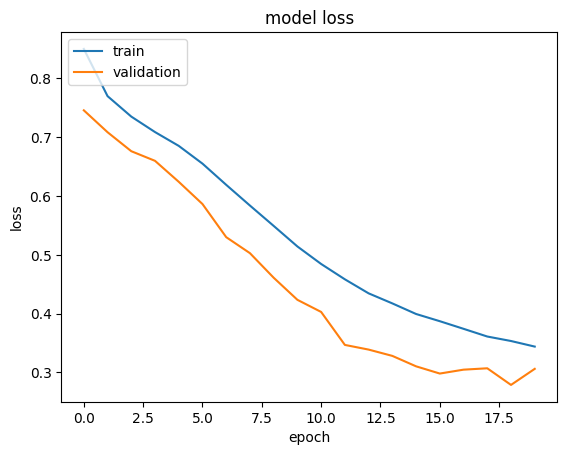

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
model_2.save('model_2.h5')

NameError: name 'model_2' is not defined

**Model 3**

In [ ]:
def get_avg_vector(text_list, model, dim):
  vecs = []
  for text in text_list:
    words = text.split()
    vector_sum = np.zeros((dim,), dtype="float32")
    n_words = 0

    for w in words:
      if w in model:
        vector_sum = np.add(vector_sum, model[w])
        n_words += 1

    if n_words > 0:
      vector_sum = np.divide(vector_sum, n_words)

    vecs.append(vector_sum)
  return np.array(vecs)

In [ ]:
X_train_w2v = get_avg_vector(X_train, w2v_model, EMBEDDING_DIM)
X_test_w2v = get_avg_vector(X_test, w2v_model, EMBEDDING_DIM)
y_label_init = np.argmax(y_train, axis=1)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_w2v, y_label_init)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_3 = clf.predict(X_test_w2v)
acc = accuracy_score(np.argmax(y_test, axis=1), y_pred_3)

print(f"Akurasi: {acc*100:.2f}%")
print(classification_report(np.argmax(y_test, axis=1), y_pred_3))

Akurasi: 66.28%
              precision    recall  f1-score   support

           0       0.62      0.67      0.64     10152
           1       0.56      0.52      0.54     10152
           2       0.81      0.79      0.80     10152

    accuracy                           0.66     30456
   macro avg       0.66      0.66      0.66     30456
weighted avg       0.66      0.66      0.66     30456



In [ ]:
with open('model_3.pkl', 'wb') as f:
  pickle.dump(clf, f)

**Test Prediksi Model**

In [ ]:
teks = "barang nya hancur banget, nyesel beli disini!!!"

In [ ]:
text_cleaned = cleaning_text(teks, normalization_dict)

text_seq = tokenizer.texts_to_sequences([text_cleaned])

text_padded = pad_sequences(text_seq, maxlen=max_len, padding='pre', truncating='pre')

**Model 1**

In [ ]:
prediction_prob = model_1.predict(text_padded)

prediction_index = np.argmax(prediction_prob)

confidence = np.max(prediction_prob) * 100

final_label = le.inverse_transform([prediction_index])[0]

In [ ]:
print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

**Model 2**

In [ ]:
prediction_prob = model_2.predict(text_padded)

prediction_index = np.argmax(prediction_prob)

confidence = np.max(prediction_prob) * 100

final_label = le.inverse_transform([prediction_index])[0]

In [ ]:
print(f"Teks: {teks}")
print(f"Label prediksi: {final_label}")
print(f"Confidence: {confidence:.2f}%")

**Model 3**

In [ ]:
text_w2v = get_avg_vector([text_cleaned], w2v_model, EMBEDDING_DIM)

prediction_index_3 = clf.predict(text_w2v)[0]

final_label_3 = le.inverse_transform([prediction_index_3])[0]

In [ ]:
print(f"Teks: {teks}")
print(f"Label prediksi: {final_label_3}")

Teks: barang nya hancur banget, nyesel beli disini!!!
Label prediksi: Negatif


**Load requirements.txt**

In [87]:
!pip freeze > requirements.txt